In [1]:
import numpy as np
import pandas as pd

# plotting 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import PyPDF2

# data manager and analysis
import vodex as vx
import numan as nu

# writing files
import tifffile as tif

run this cell to get some handy functions:

In [2]:
def merge_pdfs(pdfs, filename):
    mergeFile = PyPDF2.PdfFileMerger()
    for pdf in pdfs:
        mergeFile.append(PyPDF2.PdfFileReader(pdf, 'rb'))
        os.remove(pdf)
    mergeFile.write(filename)

# Load Cells from Json
Give the path to the spots file that you saved in the "Extracting_signal_from_imaris" notebook. 

In [3]:
spots_json = "D:/Code/repos/numerosity_2/data/processed/img/20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1/spots/dot2_vs_dot5_cells.json"
spots = nu.Spots.from_json(spots_json)
spots.list_groups()

dict_keys(['p_stim', 'p_control', 'significant', 'shape group 0', 'shape group 1', 'shape group 2', 'shape group 3', 'shape group 4', 'shape group 5'])


In [8]:
spots.groups['p_stim'][np.where(spots.groups['significant'])[0][42]]

True

In [10]:
spots.signals.T

700

# Load groups assignments from Csv

Create a csv with the groups assignment : it HAS TO have a column names groups , with a group number for each signinficant cell (the cells that were output into a pdf at the end of "Extracting_signal_from_imaris" notebook) use 0 for no group for example ... any other columns will be ignored, but I recomment making another column with cell id - it is much easier to fill out that csv and avoid errors when you have a list of ids right next to the grou passignmnet. 

In [6]:
group_csv = "D:/Code/repos/numerosity_2/data/processed/img/20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1/spots/significant_spots_groups.csv"
group_assignment = pd.read_csv(group_csv)['groups'].to_numpy()
group_assignment

array([0, 3, 3, 1, 1, 0, 1, 1, 3, 1, 0, 0, 2, 1, 1, 3, 4, 1, 4, 4, 0, 4,
       3, 4, 4, 5, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 0, 0,
       0, 3, 0, 3, 3, 0, 0, 0], dtype=int64)

Create the shape groups and add the new groups to spots ( just run it ) 

In [5]:
significant_cells = np.where(spots.groups['significant'])[0]
groups = {}
for group in np.unique(group_assignment):
    groups[f"shape group {group}"] = np.zeros((len(spots.spots),1)).astype(bool)
    groups[f"shape group {group}"][significant_cells[group_assignment==group]] = True
    
spots.add_groups(groups)
spots.list_groups()

dict_keys(['p_stim', 'p_control', 'significant', 'shape group 0', 'shape group 1', 'shape group 2', 'shape group 3', 'shape group 4', 'shape group 5'])


# Save Cells with shape groups as Json 
This will overwrite the previous json file , you can also save to a different file if you wish. 

In [38]:
spots.to_json(spots_json)

p_stim
p_control
significant
shape group 0
shape group 1
shape group 2
shape group 3
shape group 4
shape group 5


# Save different shape groups as tif 

In [40]:
# the shape of the output volume
image_volume_shape = (52, 468, 500)

for group in [0,1,2,3,4,5]:
    shape_mask = spots.get_group_mask(spots.groups[f"shape group {group}"], image_volume_shape)
    tif.imwrite(f"D:/Code/repos/numerosity_2/data/processed/img/20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1/spots/shape_group_{group}_mask.tif",
                       shape_mask.astype(np.uint16),shape=image_volume_shape, metadata={'axes': 'ZYX'}, imagej=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.39it/s]


# Plot signals wih group label

I recommend you run it to make sure that all the shape assignment was done correctly. It will create a pdf with all the significant cell, but the titles will have the group number in them. 
To run it , you need to define experiment ( for cycle information ) and create dff

In [4]:
blank = vx.Condition(vx.Stimulus('blank','blank'), name = 'Blank')
dot2 = vx.Condition(vx.Stimulus('2dot','2dot'), name = 'dot 2')
dot5 = vx.Condition(vx.Stimulus('5dot','5dot'), name = 'dot 5')

spec = {}
spec['conditions'] = [blank,dot2,
              blank,dot5]
spec['timing'] = np.array([6,1,
                   6,1])*52 # in frames
spec['project_dir'] = 'D:/Code/repos/numerosity_2/data/raw/img/20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1/'
spec['frames_per_volume'] = 52

experiment = vx.Experiment.from_dic(spec)
experiment.summary()

Total of 5 files.
Check the order :
[ 0 ] 20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1_MMStack_Pos0.ome.tif : 8910 frames
[ 1 ] 20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1_MMStack_Pos0_1.ome.tif : 8909 frames
[ 2 ] 20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1_MMStack_Pos0_2.ome.tif : 8909 frames
[ 3 ] 20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1_MMStack_Pos0_3.ome.tif : 8909 frames
[ 4 ] 20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1_MMStack_Pos0_4.ome.tif : 763 frames

Cycle length: 728
Condition ['blank']: for 312 frames
Condition ['2dot']: for 52 frames
Condition ['blank']: for 312 frames
Condition ['5dot']: for 52 frames

Total cycles (ceil): 50
Total frames : 36400
Total good volumes : 700
Frames per volume : 52



In [5]:
# get dff for each cell
sliding_window = 15 # in volumes
significant_signals = spots.get_group_signals(spots.groups['significant'])
significant_signals_dff = significant_signals.as_dff(sliding_window)
sp = nu.SignalPlotter(significant_signals_dff, experiment)

## Create a pdf with all the traces : 

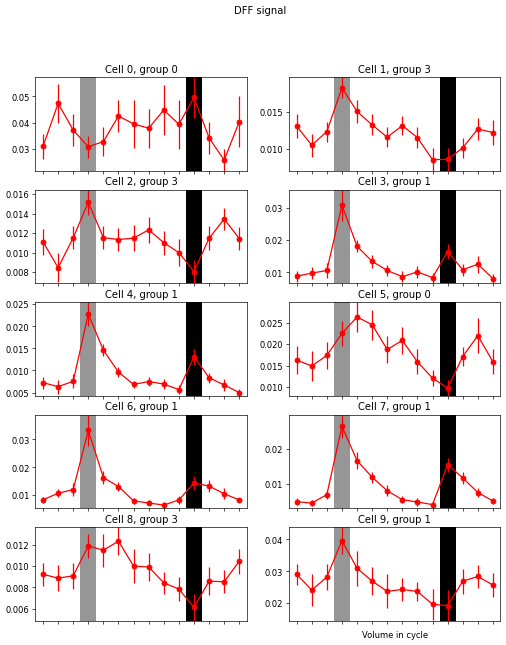

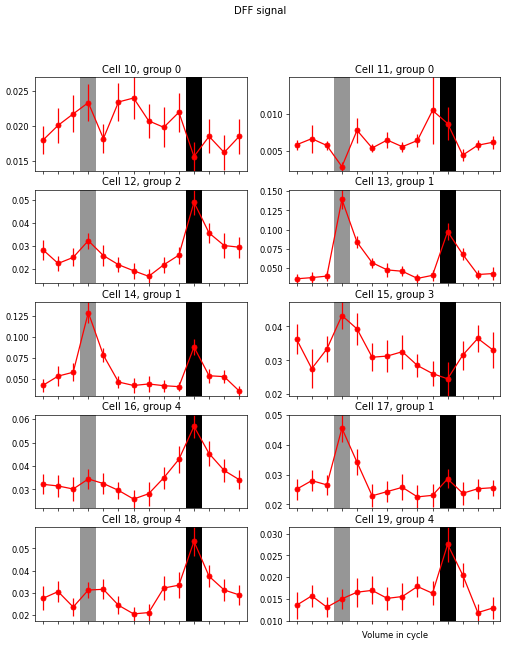

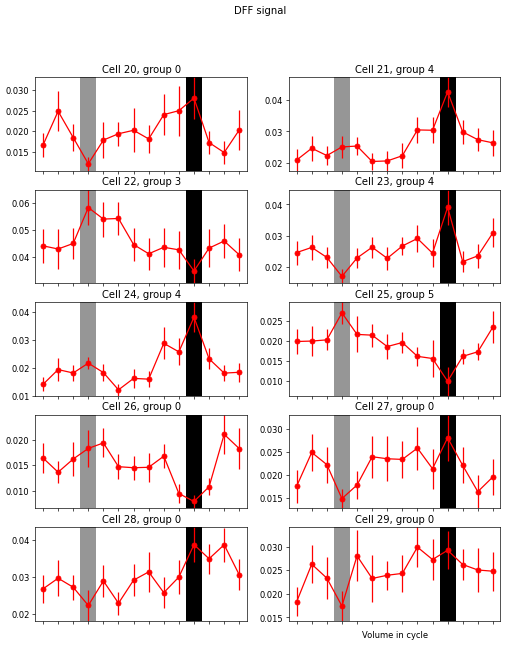

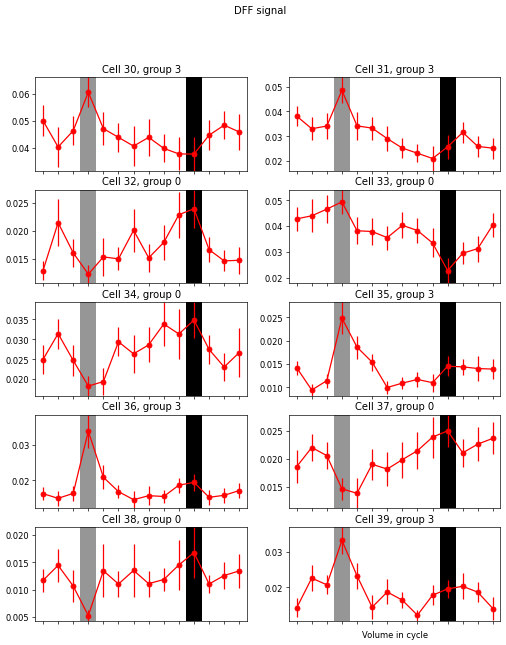

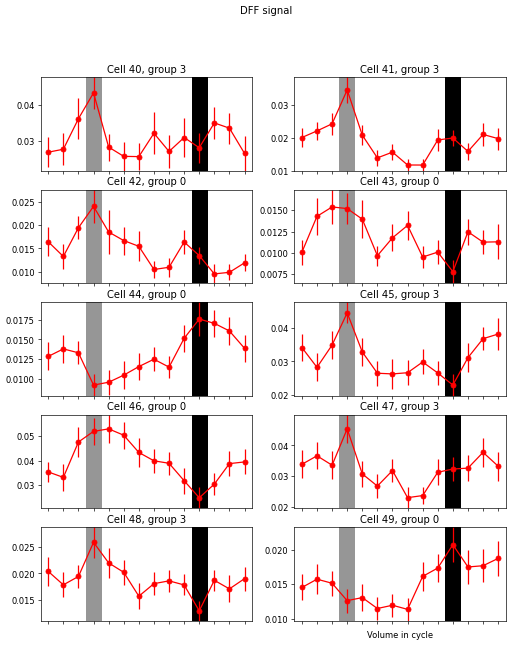

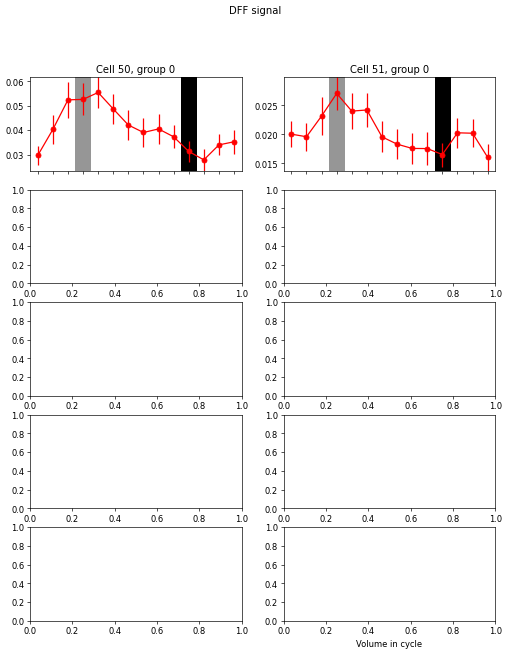

In [8]:
tpp = 10 # traces per page
cells = np.arange(sp.n_signals)
btchs = [cells[s: s+tpp] for s in np.arange(np.ceil(sp.n_signals / tpp).astype(int))*tpp]

main_title = "DFF signal"

# indifidual pdf pages will be saved to this folder, but will be deleted right after the merge 
tmp_folder = 'D:/Code/repos/numerosity_2/data/processed/img/20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1/spots/'
# filename to save pdf with all the significant traces
pdf_filename = f'D:/Code/repos/numerosity_2/data/processed/img/20211210_ce02_abtl_h2bcamp6s_8dpf_2v5_2P_1/spots/significant_signals_sem_mean_only_good_order_groupped2.pdf'

pdfs = []
for ibtch, btch in enumerate(btchs):
    titles = [f"Cell {ipt}, group {group_assignment[ipt]}" for ipt in btch]
    sp.show_psh(btch, 
                main_title, 
                titles,
                # front_to_tail will shift the cycleby the set number of voxels
                # so when set to 3, there are 3 blank volumes at the begining and at the end ... 
                # if set to 0, will have 6 leading blanks and will end right after the 5 dots (black bar)
                front_to_tail = 3, 
                # what grid to use to show the points
                figure_layout = [5,2] ,
                # what error type to use ( "sem" for SEM or "prc" for 5th - 95th percentile )
                error_type = "sem",
                # figure parameters
                figsize = (10, 12),
                dpi = 60,
                # wheather to plot the individual traces 
                plot_individual = False,
                # the color of the individual traces (if shown)
                noise_color = '--c')

    plt.xlabel('Volume in cycle')
    filename = f'{tmp_folder}signals_batch{ibtch}.pdf'
    plt.savefig(filename)
    pdfs.append(filename)
    

merge_pdfs(pdfs, pdf_filename)